In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata

In [2]:
'''
Function that runs kallisto to index reference file
fastq: fastq or fastq.gz file to be indexed for kallisto alignment
output: name of desired output file
'''
def index_transcriptome(fastq, output):
    command = "kallisto index -i " + output_name + " " + file_name
    os.system(command)

In [3]:
'''
Runs the kallisto quantification data on 
RNAseq_path: path to where all the RNAseq data is kept
output_path: path to where the output directories should be stored
metadata: file containing on each line a file name, stimulus, and group delimited by a space
index: the reference index being used
'''
def mass_alignments(RNAseq_path, output_path, metadata, index):
    # Reads through metadata to get files necessary for alignment
    with open(metadata) as f:
        for line in f:
            
            # Parse each line with the space as delimiter
            file_stim_group = line.split(" ")
            # Ignores commentted out lines in metadata (i.e. first line)
            if line[0] is '>':
                continue
            
            # Make a directory for output files to go
            directory = output_path + "/" + file_stim_group[1] + "_" + file_stim_group[2].strip()
            os.system("rm -r " + directory)
            os.system("mkdir " + directory)
            
            # Files of the reads to be align
            read1 = RNAseq_path + "/" + file_stim_group[0] + "/trimmomatic_output/" + "trimmomatic_output_L001_1P.fastq"
            read2 = RNAseq_path + "/" + file_stim_group[0] + "/trimmomatic_output/" + "trimmomatic_output_L001_2P.fastq"
            
            # Run kallisto to generate quantification and put into above directory, bootstapping value = 100
            command = "kallisto quant -i " + index + " -o " + directory + " -b 100 " + read1 + " " + read2
            os.system(command)          
                
                

In [4]:
# File path of the mouse cDNA dataset
mouse_cDNA = "/Users/jackycheung/Desktop/Coursework/Computational_Genomics/COMS4761_Project/Mus_musculus.GRCm38.cdna.all.fa.gz"

# File paths to be used for alignment
RNAseq_path = "/Volumes/Seagate\ Backup\ Plus\ Drive/PHOSPHOTRAP\ RNASEQ/K_SMARTBULK_pS6NSTPOOL_RUN001"
output_path = "/Users/jackycheung/Desktop/Coursework/Computational_Genomics/COMS4761_Project"
metadata = "/Users/jackycheung/Desktop/Coursework/Computational_Genomics/COMS4761_Project/metadata.txt"
index = "/Users/jackycheung/Desktop/Coursework/Computational_Genomics/COMS4761_Project/mouse_cDNA.idx"

# Performs the Kallisto indexing of the mouse cDNA dataset and aligns all the RNASeq files
# index_transcriptome(mouse_cDNA, mouse_cDNA.idx):
# mass_alignments(RNAseq_path, output_path, metadata, index)


In [5]:
 '''
Returns a python dictionary with key = entrez_ID and value = ensembl_ID using conversion file
conversion_text: tsv file that contains entrez_ID and ensembl_ID (along with gene description) 
'''
def conversion_dict(conversion_txt):
    # Dictionary of conversation to be returned
    conversion = {}
    
    # Parses through the conversation text
    with open(conversion_txt) as f:
        # Skips the header line in the coversion file
        next(f)
        
        # Breaks up the line and adds conversation to dictionary
        for line in f:
            columns = line.strip("\n").split("\t")
            if columns[0] == '':
                continue
            else:
                conversion[columns[0]] = columns[1]
    
    return conversion

In [7]:
entrez_to_ensembl = conversion_dict("./conversion_tables/entrez_ensemble.txt")
ensemble_t_to_g = conversion_dict("./conversion_tables/ensembl_t_g.txt")
ensemble_g_to_t = conversion_dict("./conversion_tables/ensembl_g_t.txt")

In [8]:
'''
Returns a dict that represents the metadata of counts and tsv across all CR data
metadata_file: file containing the name of the directory containing the abundance.tsv
input_path: file containing the directory all the inputs are in
'''
def phosp_meta(metadata_file, input_path):
    # Dictionary for metadata
    meta_dict = {}
    
    num_files = 0
    # Parses through the metadata file to generate all CR data name
    with open(metadata_file) as f:
        for f_line in f:
            abundance_file = input_path + "/" + f_line.strip() + "/abundance.tsv"
            num_files += 1
            
            with open(abundance_file) as a:
                next(a)
                for a_line in a:
                    
                    # Parses the counts/tpm out
                    columns = a_line.strip().split("\t")
                    ensembl_ID = columns[0]
                    counts = float(columns[3])
                    tpm = float(columns[4])
                    
                    # Handles first entry into dictionary
                    if ensembl_ID not in meta_dict:
                        meta_dict[ensembl_ID] = (counts, tpm)
                        
                    # Otherwise continue summing (averaging will be done later)
                    else:
                        meta_dict[ensembl_ID] = (meta_dict[ensembl_ID][0] + counts, meta_dict[ensembl_ID][1] + tpm)
        
        # Handles averaging of all the data here
        for ensembl_ID in meta_dict:
            meta_dict[ensembl_ID] = (meta_dict[ensembl_ID][0] / num_files, meta_dict[ensembl_ID][1] / num_files)
            
    return meta_dict

'''
Returns a dict that represents the ish data
ish_file = file that contains the ish expression data
'''
def ish_data(ish_file):
    
    # Dictionary of entrez_id with ISH data (intensity, density, energy)
    ish_dict = {}
    
    # Opens the ISH files to get values for ISH dictionary
    with open(ish_file) as f:
        # Skips the header file
        next(f)
        
        # Parses line by line and fills the ISH dictionary appropriately
        for line in f:
            columns = line.strip("/n").split(",")
            gene_id = columns[11].strip()
            # Ignore values with no entrez_id
            if gene_id == '':
                continue
            # Deals with zero expression value by setting intensity to 0
            if float(columns[4]) == 0:
                expr_intensity = 0
            else:
                expr_intensity = float(columns[6])/float(columns[4])
            expr_density = columns[7]
            expr_energy = columns[8]
            ish_dict[gene_id] = (expr_intensity, expr_density, expr_energy)
            
    return ish_dict

'''
Returns an array of tuple using the ISH Allen Brain Atlas Data and equivalent PhosphoTrap data
'''
def ish_phos_data(meta_dict, ish_dict, entrez_to_ensembl, ensemble_t_to_g, ensemble_g_to_t):
    # Array of tuples containing data in (Ensembl_Gene, Intensity, Density, Energy, Avg_Count, Avg_tphttps://stackoverflow.com/questions/15578331/save-list-of-ordered-tuples-as-csvm) format
    ish_phos_meta = []
    entrez_ensemble = 0
    no_entrez_ensemble = 0
    no_equiv_transcript = 0
    for entrez_id in ish_dict:
        # Checks to see if a conversion exist, skip if does not exist
        if entrez_id not in entrez_to_ensembl:
            no_entrez_ensemble += 1
            continue
        # Get equivalenet ensemble gene and transcript version
        entrez_ensemble += 1
        ensembl_g = entrez_to_ensembl[entrez_id]
        ensembl_t = ensemble_g_to_t[ensembl_g]
        # Check to see if this entry exist in PhosphoTrap data, skip if does not exist
        if ensembl_t not in meta_dict:
            no_equiv_transcript += 1
            continue
        # Puts entry into ish_phos_meta
        intensity = ish_dict[entrez_id][0]
        density = ish_dict[entrez_id][1]
        energy = ish_dict[entrez_id][2]
        avg_count = meta_dict[ensembl_t][0]
        avg_tpm = meta_dict[ensembl_t][1]
        ish_phos_meta.append((ensembl_g, intensity, density, energy, avg_count, avg_tpm))
    
    print("Number of Entrez ID with Ensemble_g Mapping: ", entrez_ensemble)
    print("Number of Entrez ID with no Ensemble_g Mapping: ", no_entrez_ensemble)
    print("Number of ISH data with no representation in PhosphoTrap Data: ", no_equiv_transcript)
    
    return ish_phos_meta

'''
Converts a array of tuples to a csv files
Taken from: https://stackoverflow.com/questions/15578331/save-list-of-ordered-tuples-as-csv
'''
def convert_to_csv(array_input, output_name):
    with open(output_name,'w') as f:
        csv_output =csv.writer(f)
        csv_output.writerow(['Ensemble_ID','Intensity', 'Density', 'Energy', 'Avg_Count', 'Avg_TPM'])
        for row in array_input:
            csv_output.writerow(row)

In [9]:
meta_dict = phosp_meta("./results/CR_metadata.txt", "./results")
ish_dict = ish_data("./structure_union_NST.csv")
full_data = ish_phos_data(meta_dict, ish_dict, entrez_to_ensembl, ensemble_t_to_g, ensemble_g_to_t)
convert_to_csv(full_data , './output.csv')

Number of Entrez ID with Ensemble_g Mapping:  17316
Number of Entrez ID with no Ensemble_g Mapping:  2102
Number of ISH data with no representation in PhosphoTrap Data:  30


In [10]:
geneID_arr = []
intensity_arr = []
density_arr = []
energy_arr = []
count_arr = []
tpms_arr = []
    
with open("./output.csv") as f:
    next(f)
        
    for line in f:
        columns = line.strip("\n").split(",")
        gene_ID = columns[0]
        intensity = float(columns[1])
        density = float(columns[2])
        energy = float(columns[3])
        avg_count = float(columns[4])
        avg_tpms = float(columns[5])

        geneID_arr.append(gene_ID)
        intensity_arr.append(intensity)
        density_arr.append(density)
        energy_arr.append(energy)
        count_arr.append(avg_count)
        tpms_arr.append(avg_tpms)
        
    
ranked_intensity = len(intensity_arr) - rankdata(intensity_arr).astype(int)
ranked_density = len(density_arr) - rankdata(density_arr).astype(int)
ranked_energy = len(energy_arr) - rankdata(energy_arr).astype(int)
ranked_count = len(count_arr) - rankdata(count_arr).astype(int)
ranked_tpms = len(tpms_arr) - rankdata(tpms_arr).astype(int)

In [11]:
print(len(ranked_intensity))
print(len(ranked_density))
print(len(ranked_energy))
print(len(ranked_count))
print(len(ranked_tpms))

17286
17286
17286
17286
17286


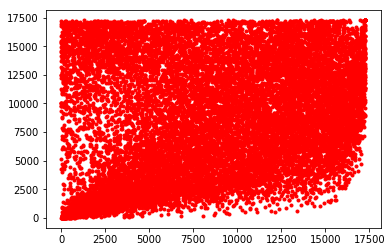

In [12]:
plt.plot(ranked_intensity, ranked_density,'r.')
plt.show()

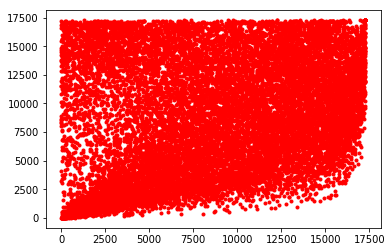

In [13]:
plt.plot(ranked_intensity, ranked_energy,'r.')
plt.show()

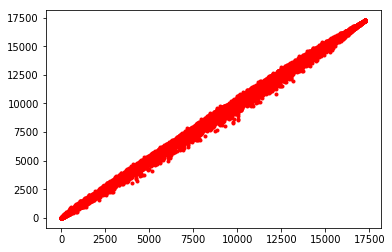

In [14]:
plt.plot(ranked_density, ranked_energy,'r.')
plt.show()

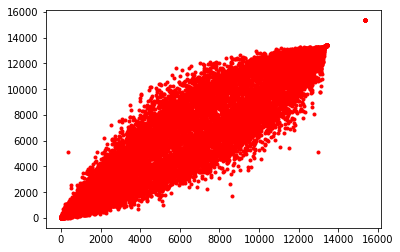

In [16]:
plt.plot(ranked_count, ranked_tpms,'r.')
plt.show()

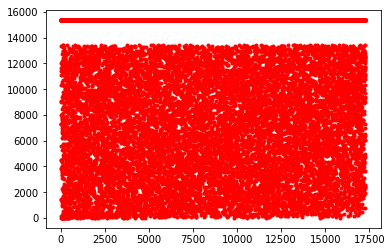

In [17]:
plt.plot(ranked_intensity, ranked_count,'r.')
plt.show()

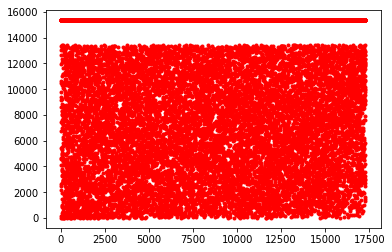

In [18]:
plt.plot(ranked_intensity, ranked_tpms,'r.')
plt.show()

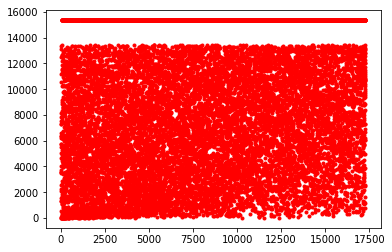

In [19]:
plt.plot(ranked_density, ranked_count,'r.')
plt.show()

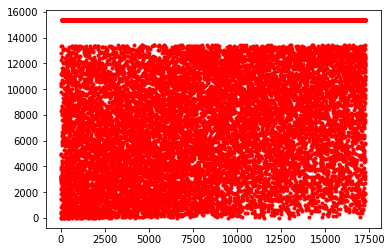

In [20]:
plt.plot(ranked_density, ranked_tpms,'r.')
plt.show()

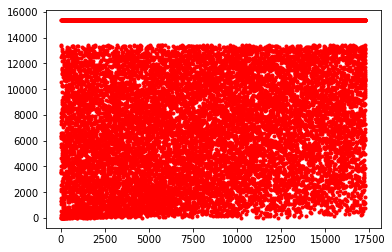

In [21]:
plt.plot(ranked_energy, ranked_count,'r.')
plt.show()

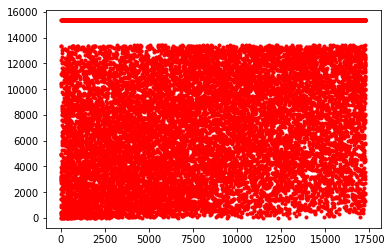

In [22]:
plt.plot(ranked_energy, ranked_tpms,'r.')
plt.show()